# ML FLow x Prefect

Prefect and MLflow are two different tools with different use cases, but there can be some overlap in the context of data science and machine learning workflows.

1. **Prefect** is a workflow management system built in Python. It's designed to help data scientists and data engineers build, test, and run data workflows. Prefect workflows consist of tasks that form a directed acyclic graph (DAG), and Prefect takes care of running those tasks in the correct order, handling failures, and logging what happened. It can be used to orchestrate complex machine learning pipelines but is not specifically designed for machine learning.

2. **MLflow**, on the other hand, is an open-source platform specifically designed for managing the end-to-end machine learning lifecycle. It includes tools for tracking experiments, packaging code into reproducible runs, managing and deploying models. Here's a breakdown of MLflow's main components:
    - **MLflow Tracking**: for logging and querying experiments, including code, data, config, and results.
    - **MLflow Projects**: for packaging ML code in a reusable, reproducible form to share with other data scientists or transfer to production.
    - **MLflow Models**: for managing and deploying models from different ML libraries to a variety of model serving and inference platforms.
    - **MLflow Model Registry**: for collaborative model lifecycle management.

In summary, Prefect is more of a general-purpose data workflow tool that's useful in a variety of contexts, including but not limited to machine learning. MLflow, on the other hand, is specifically built to manage various stages in the machine learning lifecycle, including experimentation, reproducibility, and deployment. They can even be used together: Prefect can be used to orchestrate an MLflow-based machine learning workflow.

# ML Flow Roadmap

With ML flow there is a few things we need to do. First we need to set a tracking URI which tells ML FLow which server we want to store everything on. We will be using Le Wagon's server, but if you had your own server, this is where you would pass it:

In [2]:
import mlflow

mlflow.set_tracking_uri("https://mlflow.lewagon.ai")
mlflow.set_experiment(experiment_name="wagoncab taxifare") # choose an experiment name

Then start a run. Note that this is a reproduceable piece of code. We do not have to re-write it for every single run. All we have to do is reuse it by passing a `python decorator` in our packages - we'll see how that wotks in a little bit.

In [ ]:
with mlflow.start_run():

    params = dict(batch_size=256, row_count=100_000)
    metrics = dict(rmse=0.456)

    mlflow.log_params(params)
    mlflow.log_metrics(metrics)

    mlflow.tensorflow.log_model(model=model,
                                artifact_path="model",
                                registered_model_name="taxifare_model"
    )

Finally, the more critical part is getting the model back - once we do that, we load the model:

In [2]:
# LOAD MODEL
import mlflow

# we have to do this so mlflow knows which server its working with
mlflow.set_tracking_uri("https://mlflow.lewagon.ai")

# on the server there will be a path to that model
model_uri = "models:/taxifare_model/Production"

# finally we load the model
model = mlflow.tensorflow.load_model(model_uri=source)

**This is nice, but where does this go in our package?**

First, we will explore the `mlflow_run` decorator in `ml_logic/registry.py`. Here we will:
- add parameters
- add metrics
- store model
- make a prediciton with the stored model

Let's check the `mlflow_run` function.

In [ ]:
# registry.py

def mlflow_run(func):
    """
    Generic function to log params and results to MLflow along with TensorFlow auto-logging

    Args:
        - func (function): Function you want to run within the MLflow run
        - params (dict, optional): Params to add to the run in MLflow. Defaults to None.
        - context (str, optional): Param describing the context of the run. Defaults to "Train".
    """
    def wrapper(*args, **kwargs):
        mlflow.end_run()
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI) # variable set in our .env file
        mlflow.set_experiment(experiment_name=MLFLOW_EXPERIMENT) # variable set in our .env file
        # starts the run
        with mlflow.start_run():
            # automatically does the parameters and metrics so we don't have 
            # to specify every single parameter and metrics that we need
            # autolog will save absolutely everything it can find about this training
            mlflow.tensorflow.autolog()
            # here we run the original function that was decorated
            results = func(*args, **kwargs)

        print("✅ mlflow_run auto-log done")
        # here we return the results of that function
        return results
    # here we return the wrapper function
    return wrapper


The `mlflow_run` function is a decorator designed to log parameters and results to MLflow, a platform for managing the machine learning lifecycle. Let's break down how it works:

1. **Function Signature**:
   - `mlflow_run` takes a single argument `func`, which is the function you want to run within the MLflow run.

2. **Wrapper Function**:
   - Inside `mlflow_run`, there is a nested function called `wrapper(*args, **kwargs)`.
   - This `wrapper` function is what actually wraps around the original function (`func`) and executes additional logic before and after running `func`.
   - It accepts any number of positional and keyword arguments (`*args` and `**kwargs`) to be passed to the original function.

3. **MLflow Configuration**:
   - The `mlflow.end_run()` function is called at the beginning of the wrapper to ensure that any existing MLflow run is ended before starting a new one.
   - `mlflow.set_tracking_uri()` is used to set the URI where MLflow is tracking experiments. The URI is read from an environment variable (`MLFLOW_TRACKING_URI`), which is set in a configuration file.
   - `mlflow.set_experiment()` is called to specify the MLflow experiment to which the run belongs. The experiment name is typically read from another environment variable (`MLFLOW_EXPERIMENT`), which is set in the configuration file.

4. **MLflow Autologging**:
   - Inside the `with mlflow.start_run()` context manager, MLflow's autologging feature for TensorFlow (`mlflow.tensorflow.autolog()`) is enabled.
   - Autologging automatically logs various parameters and metrics captured during the training process, such as model hyperparameters, performance metrics, and training artifacts. This reduces the need for manual logging of individual parameters and metrics.

5. **Executing the Original Function**:
   - The original function (`func`) is called within the `with mlflow.start_run()` block, and its results are stored in the `results` variable.

6. **Returning Results**:
   - Finally, the `results` of the original function are returned after the MLflow run is completed.

7. **Print Statement**:
   - A print statement is included to indicate that the MLflow autologging process is completed.

8. **Return the Wrapper Function**:
   - The `wrapper` function is returned from `mlflow_run`, effectively replacing the original function `func` when `mlflow_run` is used as a decorator.

So basically, `mlflow_run` is a decorator that wraps around a function, configures MLflow settings, starts an MLflow run, enables autologging for TensorFlow, executes the original function, and returns its results, all while automatically logging relevant information to MLflow. This simplifies the process of logging experiments and results when working with MLflow.

- The `wrapper(*args, **kwargs)` is a common pattern used in Python for creating decorators or wrapper functions.
- *args: The asterisk (*) preceding args indicates that this parameter is used to collect any number of positional arguments passed to the function. It collects these arguments into a tuple. When you define a function with *args, you can call it with any number of positional arguments, and they will all be captured and stored in the args tuple inside the function.
- **kwargs: The double asterisks (**) preceding kwargs indicates that this parameter is used to collect any number of keyword arguments passed to the function. It collects these arguments into a dictionary. When you define a function with **kwargs, you can call it with any number of keyword arguments (key-value pairs), and they will all be captured and stored in the kwargs dictionary inside the function.

Putting them together, wrapper(*args, **kwargs) is a function definition where *args captures any number of positional arguments, and **kwargs captures any number of keyword arguments. This allows the wrapper function to accept a variable number of arguments in a flexible manner.

Now we need to update our `.env` file so that it has the correct environment variables for mlflow.

In [ ]:
MODEL_TARGET=mlflow

# Model Lifecycle
MLFLOW_TRACKING_URI=https://mlflow.lewagon.ai # this is le wagon's server.
MLFLOW_EXPERIMENT=taxifare_experiment_<experiment_name>
MLFLOW_MODEL_NAME=taxifare_<experiment_name>

Now we need to make sure the decorator is added to the training. So we'll go to `interface/main.py` and look at the function `def train`. You will notice that is an `@mlflow_run` decorator right above the function. This means that the decorator will run the `mlflow_run` funtion before it executes the train function.

Let's test and see what happens!

1. run `make run_train`
2. head over to the website and check your experiment https://mlflow.lewagon.ai/
3. search your experiment by experiment name
4. and voilà!
5. There you can see the details of your run - be curious dig around. Click on the `Run name`column to take a look at your metrics tab. if wew look at our loss chart it look s kinda crazy becasue we only trained it on 1k rows but given that we trained it in a full dataset, we'd see a nice declining loss over time, same with mae... We have 26 parameters - that is because of the autologging that we used in our function. When the tensorflow happens within that decorator, it will pick up absolutely everything about that tensorflow training.

Now we want to store our model. At the moment, in our `main.py` file we have the `df train` function that contains a `save_model` function call. `ctrl + right-click` the `save_model` function to be taken to where the function is at. It's inside `registry.py`. Below the `if MODELT_TARGET == 'gcs'` line, we'll add:

In [ ]:
if MODEL_TARGET ==  'mlflow':
        mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
        mlflow.tensorflow.log_model(model,
                                    registered_model_name=MLFLOW_MODEL_NAME,
                                    artifact_path='models')

So here we check if the value of the variable `MODEL_TARGET` is equal to the string `'mlflow'`. If the condition is true, it sets up MLflow tracking for logging a TensorFlow model.

- `mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)` sets the URI where MLflow should track experiments. 
- The URI is typically a URL pointing to an MLflow server where experiment data is stored. It is read from the environment variable `MLFLOW_TRACKING_URI`.

- The we Logg the TensorFlow Model.
- `mlflow.tensorflow.log_model(model, registered_model_name=MLFLOW_MODEL_NAME, artifact_path='models')` logs the TensorFlow model to MLflow.
- It logs the model `model` with a registered model name specified by the variable `MLFLOW_MODEL_NAME`.
- The `artifact_path` parameter determines the location within the MLflow artifacts where the model will be saved. In this case, it's saved in the `models` directory.
- MLflow automatically tracks all the relevant information about the model, including its architecture, weights, and other metadata.

Now, when we run `make run_train`, you will be able to actually access a version of your model and will also able to call it back to python if you want to! So Let'a rerun `make run_train` and go back to the experiment on the website. 

Now, when you click on the `models` column, you have a fully usable model that can be pulled back into python to make a prediciton with.

#### Let's load our model back in for prediction. Go to `registry.py` and find the `def load_model` function and write some code:

In [ ]:
#[...]

elif MODEL_TARGET == "mlflow":
    print(Fore.BLUE + f"\nLoad [{stage}] model from MLflow..." + Style.RESET_ALL)

    # Load model from MLflow
    model = None
    # set the tracking URI as always
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    # create a client to interact with the server and pull down the path to our latest model
    client = mlflow.tracking.MlflowClient()
    # gets the lates versions of our model
    version = client.get_latest_versions(MLFLOW_MODEL_NAME)
    # version is a list containin the ModelVersion Object. Here we access the model
    # then the model attribute .source to get the path (try printing it out in the console!)
    model_uri = version[0].source
    # here we load our model
    model = mlflow.tensorflow.load_model(model_uri=model_uri)
    return model
else:
    return None

### Why version[0]?

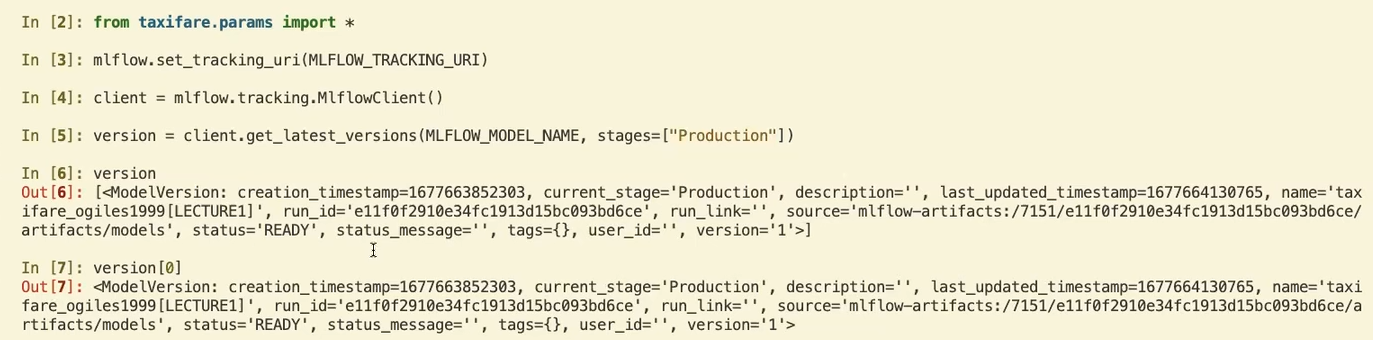

Run a `make run_pred` to get the predicition.

# Back to lecture

# Automate the model lifecycle with prefect

Create e new file called `workflow.py` inside the interface directory.

In [4]:
# workflow.py

# we take previous functions we wrote
from taxifare.interface.main import evaluate, preprocess, train


def preprocess_new_data(min_date: str, max_date: str):
    # takes the dates as parameters for one month of data
    preprocess(min_date=min_date, max_date=max_date)


def evaluate_production_model(min_date: str, max_date: str):
    # we call the evaluate function to evaluate the production model
    # the evaluate functions calls the 'load_model' function so that it loads
    #  the in production model so we are evaluating the production model(our default stage is production)
    eval_mae = evaluate(min_date=min_date, max_date=max_date)
    return eval_mae


def re_train(min_date: str, max_date: str):
    # retrains model on new data
    # updates the split ratio to take 20% of the new month as a validation set
    train_mae = train(min_date=min_date, max_date=max_date, split_ratio=0.2) 
    return train_mae


def train_flow():
    # realistically this will be a function calculation the time period
    min_date = "2015-01-01"
    max_date = "2015-02-01"
    preprocess_new_data(min_date, max_date)
    old_mae = evaluate_production_model(min_date, max_date)
    new_mae = re_train(min_date, max_date)

if __name__ == "__main__":
    train_flow()

This script, `workflow.py`, defines a workflow for training, evaluating, and retraining a machine learning model for predicting taxi fares. Let's break down each function and its purpose:

1. **Preprocess New Data (`preprocess_new_data`)**:
   - This function takes two parameters, `min_date` and `max_date`, representing the start and end dates for a one-month period of new data.
   - It calls the `preprocess` function from the `taxifare.interface.main` module to preprocess the new data within the specified date range.

2. **Evaluate Production Model (`evaluate_production_model`)**:
   - This function also takes `min_date` and `max_date` as parameters.
   - It calls the `evaluate` function from the `taxifare.interface.main` module to evaluate the production model using data within the specified date range.
   - The `evaluate` function internally loads the production model using the `load_model` function and then evaluates its performance using the provided data.

3. **Re-train Model (`re_train`)**:
   - Similar to the other functions, it takes `min_date` and `max_date` as parameters.
   - It calls the `train` function from the `taxifare.interface.main` module to retrain the model using data within the specified date range.
   - Additionally, it sets the split ratio parameter to 0.2, indicating that 20% of the new month's data will be used as a validation set during training.

4. **Train Flow (`train_flow`)**:
   - This function orchestrates the entire workflow.
   - It defines `min_date` and `max_date` to specify the time period for which the model will be trained and evaluated.
   - It sequentially calls `preprocess_new_data`, `evaluate_production_model`, and `re_train` to preprocess new data, evaluate the production model, and retrain the model, respectively.

5. **Main Block (`if __name__ == "__main__":`)**:
   - This block is executed when the script is run directly.
   - It calls the `train_flow` function to execute the defined workflow.

Overall, `workflow.py` encapsulates the end-to-end process of training, evaluating, and retraining a machine learning model for taxi fare prediction. It provides a structured approach for managing and executing these tasks within a single script.

Run the file `python taxifare/interface/workflow.py`

But right now this is really not doing anything other than running the functions on a new month of data. We need to make this more powerful.

First we need to conect to prefect. so run `prefect cloud login` in the terminal.

Now that we are conected, we need to change our code to run in the prefect interface as well.

In [ ]:
from taxifare.interface.main import evaluate, preprocess, train
from prefect import task, flow


@task
def preprocess_new_data(min_date: str, max_date: str):
    preprocess(min_date=min_date, max_date=max_date)

@task
def evaluate_production_model(min_date: str, max_date: str):
    eval_mae = evaluate(min_date=min_date, max_date=max_date)
    return eval_mae

@task
def re_train(min_date: str, max_date: str):
    train_mae = train(min_date=min_date, max_date=max_date, split_ratio=0.2)
    return train_mae

@flow
def train_flow():
    min_date = "2015-01-01"
    max_date = "2015-02-01"
    preprocess_new_data(min_date, max_date)
    old_mae = evaluate_production_model(min_date, max_date)
    new_mae = re_train(min_date, max_date)

if __name__ == "__main__":
    train_flow()

Run the file python `taxifare/interface/workflow.py`

This is all nice and cool but it doenst solve the problem we were suggesting. We have 3 tasks here running separately, one at the time. As oyu can see, one task start, and the other task waits for that same task to finish to start. 
So what we need to do to solve the problem we are sugesting is to make 2 tasks run in paralell. For that, all we have to do is go to the `workflow.py` and change the `train_flow` function:

In [ ]:
@flow
def train_flow():
    min_date = "2015-01-01"
    max_date = "2015-02-01"
    processed = preprocess_new_data.submit(min_date, max_date)
    old_mae = evaluate_production_model.submit(min_date, max_date)
    new_mae = re_train.submit(min_date, max_date)

In this function, three tasks are submitted for execution asynchronously. Let's break down each line:

1. **`min_date` and `max_date` Assignment**:
   - `min_date = "2015-01-01"` and `max_date = "2015-02-01"`: These lines assign specific dates to `min_date` and `max_date`. These dates likely represent a time period for which the machine learning model will be trained and evaluated.

2. **Submitting Tasks for Execution**:
   - `processed = preprocess_new_data.submit(min_date, max_date)`: This line submits the `preprocess_new_data` task for execution asynchronously. The `submit()` method is typically used in task orchestration frameworks to initiate task execution. It passes `min_date` and `max_date` as arguments to the `preprocess_new_data` task.
   - `old_mae = evaluate_production_model.submit(min_date, max_date)`: Similarly, this line submits the `evaluate_production_model` task for execution asynchronously. It passes `min_date` and `max_date` as arguments to the `evaluate_production_model` task.
   - `new_mae = re_train.submit(min_date, max_date)`: This line submits the `re_train` task for execution asynchronously. It passes `min_date` and `max_date` as arguments to the `re_train` task.

Basically, the `train_flow()` function submits three tasks (`preprocess_new_data`, `evaluate_production_model`, and `re_train`) for execution asynchronously, each with specific `min_date` and `max_date` parameters. These tasks are part of a workflow for training, evaluating, and retraining a machine learning model. The function's purpose is to initiate the execution of these tasks in a coordinated manner as part of the overall workflow automation process.

Run the file python `taxifare/interface/workflow.py`

Now we have all three taks running at the same time! But that is still not what we want. What we need is to parallelize evaluation and training. For that we need to add the following parameter to the functions calls:

In [ ]:
@flow
def train_flow():
    min_date = "2015-01-01"
    max_date = "2015-02-01"
    processed = preprocess_new_data.submit(min_date, max_date)
    old_mae = evaluate_production_model.submit(min_date, max_date, wait_for=[processed])
    new_mae = re_train.submit(min_date, max_date, wait_for=[processed])

`wait_for=[processed]`, the wait_for parameter specifies that the re_train task should wait for the completion of the processed task before it starts its execution.

Congratulations! You have just Automated your model's lifecycle!

Parallelizing tasks offers several advantages in various contexts, including:

1. **Reduced Execution Time**: By executing tasks concurrently, parallelization can significantly reduce the overall execution time of a workflow. Tasks that do not have dependencies on each other can run simultaneously, leading to faster completion of the entire process.

2. **Improved Resource Utilization**: Parallelization allows for better utilization of available resources, such as CPU cores or computing nodes. By running multiple tasks concurrently, idle resources can be utilized effectively, maximizing throughput and efficiency.

3. **Scalability**: Parallelization enables scaling out the execution of tasks across multiple machines or computing nodes. This scalability allows workflows to handle larger volumes of data or more complex computations by distributing the workload across multiple resources.

4. **Enhanced Performance**: Parallel execution can improve the performance of computational tasks, especially those that involve heavy computation or data processing. By leveraging multiple processing units simultaneously, tasks can be completed more quickly, leading to better performance.

5. **Concurrency and Responsiveness**: Parallelization enables concurrent execution of independent tasks, which can improve the responsiveness of systems, especially in interactive applications or real-time processing scenarios. Users can experience faster feedback or results as tasks are processed concurrently.

6. **Fault Tolerance and Robustness**: Parallelized workflows can be more resilient to failures or errors. If one task fails, it does not necessarily impact the execution of other tasks, as long as they do not depend on the failed task. This fault tolerance enhances the robustness of the overall workflow.

7. **Optimized Resource Management**: Parallelization allows for better management of resources, such as memory and disk space. Tasks can be allocated resources dynamically based on availability and requirements, optimizing resource usage and minimizing wastage.

Overall, parallelizing tasks offers several benefits, including improved performance, scalability, resource utilization, and fault tolerance. It enables efficient execution of workflows in various computing environments, ranging from single machines to distributed systems.

# Structure with agents

In Prefect, agents play a crucial role in orchestrating the execution of workflows. They are responsible for interfacing between Prefect Server and the computing environment where tasks are executed. Here's a breakdown of the structure with agents in Prefect:

1. **Prefect Server**:
   - Prefect Server is the central hub where workflow definitions, parameters, states, and results are stored. It acts as the control plane for workflow execution and monitoring.

2. **Agents**:
   - Agents are components responsible for executing tasks defined in Prefect workflows. They interact with Prefect Server to retrieve workflow definitions and submit task runs for execution. Agents are responsible for managing the execution environment, monitoring task runs, and reporting back to Prefect Server.

3. **Computing Environment**:
   - Agents execute tasks in a computing environment, which could be a local machine, a cloud-based virtual machine, or a cluster of machines. The computing environment should have access to resources required for task execution, such as computing power, memory, storage, and network connectivity.

4. **Task Execution**:
   - When a workflow is scheduled for execution, Prefect Server communicates with the configured agent to initiate task runs. The agent retrieves task definitions from Prefect Server, schedules task runs, and executes them in the computing environment.

5. **Task Monitoring and Reporting**:
   - Agents monitor the execution of tasks and report back to Prefect Server. They provide real-time updates on task status, execution progress, resource usage, and any errors or exceptions encountered during execution.

6. **Agent Configuration**:
   - Agents are configured with specific settings, such as authentication credentials, execution environment specifications, logging options, and scheduling parameters. These configurations determine how tasks are executed and monitored by the agent.

7. **Agent Types**:
   - Prefect supports various types of agents to accommodate different execution environments and use cases. Some common types of agents include:
     - LocalAgent: Executes tasks on a local machine.
     - DockerAgent: Executes tasks within Docker containers.
     - KubernetesAgent: Executes tasks within Kubernetes clusters.
     - CloudAgent: Executes tasks in cloud-based computing environments (e.g., AWS, Azure, GCP).

8. **Workflow Scheduling and Orchestration**:
   - Agents play a key role in workflow scheduling and orchestration. They ensure that tasks are executed according to the specified schedule, dependencies, and resource constraints. Agents coordinate task execution to optimize resource utilization and workflow performance.

Overall, agents serve as the bridge between Prefect Server and the computing environment, enabling the seamless execution and monitoring of workflows across different infrastructure setups. They provide flexibility, scalability, and reliability in managing workflow execution in diverse computing environments.

# Why do we need agents ❓

# Why would we self-host a server vs the cloud ❓

# Your turn! 🚀